**Import libraries**

----

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

**Load data**

----

In [27]:
class Batch:
    def __init__(self, mini_batch):
        self.mini_batch = np.array(mini_batch)
    
    def __len__(self):
        return self.mini_batch.shape[0]
    
    def __getitem__(self, idx):
        return self.mini_batch[idx]
    
    @property
    def max(self):
        return self.mini_batch.max()
        
    def peak_index_extractor(self, perc):
        '''Extract peak indexes in numpy array higher than threshold'''
        
        x = self.mini_batch
        xmin = x.max() * perc / 100
        x = x - xmin
        x[x < 0] = 0
        peak_storage = []
        for i in range(1,len(x)-1):
            if (x[i-1] < x[i] ) and ( x[i+1] < x[i] ):
                peak_storage.append(i)
        return peak_storage
    
    def max_len_bw_peaks(self, perc):
        '''Calculate maximum lenght between peak neighboorhood'''
    
        old_x_hat = 0
        max_len = 0
        for x_hat in self.peak_index_extractor(perc):
            if (x_hat - old_x_hat) > max_len: 
                max_len = x_hat -old_x_hat 
                v_max = [old_x_hat, x_hat]
            old_x_hat = x_hat
        return max_len
    
    def min_len_bw_peaks(self, perc):
        '''Calculate minimum lenght between peak neighboorhood'''
        
        old_x_hat = 0
        min_len = 25000
        for x_hat in self.peak_index_extractor(perc):
            if (x_hat - old_x_hat) < min_len: 
                min_len = x_hat - old_x_hat 
                v_min = [old_x_hat, x_hat]
            old_x_hat = x_hat
        return min_len
    
    def avg_len_bw_peaks(self, perc):
        '''Calculate average lenght between peak neighboorhood'''

        old_x_hat = 0
        avg_len = 0
        cnt = 0
        for x_hat in self.peak_index_extractor(perc):
            avg_len += (x_hat - old_x_hat)
            old_x_hat = x_hat
            cnt += 1
        return avg_len / cnt
    
    @property
    def features(self):
        '''Extract features from given time buffer'''
        
        data_features = np.array([np.average(self.mini_batch)])
        data_features = np.append(data_features, self.mini_batch.max())
        
        data_features = np.append(data_features, len(self.peak_index_extractor(0)))
        data_features = np.append(data_features, self.min_len_bw_peaks(0))
        data_features = np.append(data_features, self.max_len_bw_peaks(0))
        data_features = np.append(data_features, self.avg_len_bw_peaks(0))
        
        data_features = np.append(data_features, len(self.peak_index_extractor(10)))
        data_features = np.append(data_features, self.min_len_bw_peaks(10))
        data_features = np.append(data_features, self.max_len_bw_peaks(10))
        data_features = np.append(data_features, self.avg_len_bw_peaks(10))
        
        data_features = np.append(data_features, len(self.peak_index_extractor(50)))
        data_features = np.append(data_features, self.min_len_bw_peaks(50))
        data_features = np.append(data_features, self.max_len_bw_peaks(50))
        data_features = np.append(data_features, self.avg_len_bw_peaks(50))
        
        data_features = np.append(data_features, len(self.peak_index_extractor(90)))
        data_features = np.append(data_features, self.min_len_bw_peaks(90))
        data_features = np.append(data_features, self.max_len_bw_peaks(90))
        data_features = np.append(data_features, self.avg_len_bw_peaks(90))
        
        return data_features
    
    def print_features(self):
        feature_map = self.features
        for idx in range(len(feature_map)//4):
            print ("peak_count", feature_map[idx*4 + 2])
            print ("min_len", feature_map[idx*4 + 3])
            print ("max_len", feature_map[idx*4 + 4])
            print ("avg_len", feature_map[idx*4 + 5],'\n')

In [28]:
class MyDataLoader:
    def __init__(self, ms=1000):
        
        self.ms = ms
        self.dataset_location = "./data"
        self.dataset = None
        self.alpha_dataset = np.array([])
        self.beta_dataset = np.array([])
        self.background_dataset = np.array([])
        self.X = None
        self.Y = None
    
    @property
    def shape(self):
        return self.X.shape
        
    def read_file(self, i, j):
        '''Получим входные вектора'''
        
        f = open('./data/%s_%s.txt' %(i,j))
        data = []
        for line in f:
            data.append(float(line))
        data = np.array(data)
        return data
    
    def share_data(self, data, ms):
        '''Разделим выборку на батчи с интервалов ms (мс)'''
        
        ms = 10 * ms  // 4
        shared_data = []
        for iter in range(len(data)//ms):
            mini_batch = Batch(data[iter*ms:(iter+1)*ms])
            shared_data.append(mini_batch)
        return shared_data
    
    def normalize(self, x, mean, std):
        '''Normalize data'''
        
        x = x - mean - std
        x[x < 0] = 0
        return x
    
    def load_dataset(self):
        '''Загрузим датасет'''
        
        for i in range(1, 2):
            self.background_dataset = np.concatenate((self.background_dataset, self.read_file(i,1)), axis=0)
            self.alpha_dataset = np.concatenate((self.alpha_dataset, self.read_file(i,2)), axis=0)
            self.beta_dataset = np.concatenate((self.beta_dataset, self.read_file(i,3)), axis=0)
        '''std и mean правильней брать общим, например, мы первую секунду ничего не делаем и собираем данные \
            о фоне и его математических характеристиках, как mean(), std(). \
            В данном случае можно сделать именно так. Верно подмечено. '''   
        '''TODO: привести данные к виду [0;1] путем деления всех данных на alpha_dataset.max()'''
         
        mean, std = self.background_dataset.mean(), self.background_dataset.std()
        
        self.background_dataset = self.normalize(self.background_dataset, mean, std)
        self.alpha_dataset = self.normalize(self.alpha_dataset, mean, std)
        self.beta_dataset = self.normalize(self.beta_dataset, mean, std)
        
        self.background_dataset = self.share_data(self.background_dataset, self.ms)
        self.alpha_dataset = self.share_data(self.alpha_dataset, self.ms)
        self.beta_dataset = self.share_data(self.beta_dataset, self.ms) 
    
    def extract_feature_map(self, dataset):
        '''Extract feature map from given dataset'''
        
        feature_map = []
        for data in dataset:
            feature_map.append(data.features)
        feature_map = np.array(feature_map)
        feature_map = np.expand_dims(feature_map, axis=1)
        return feature_map
    
    def generate_inputs_labels(self):
        '''Generate inputs and labels for given datasets'''
        
        alpha_inputs = self.extract_feature_map(self.alpha_dataset)
        beta_inputs = self.extract_feature_map(self.beta_dataset)
        back_inputs = self.extract_feature_map(self.background_dataset)
        
        alpha_labels = np.array([1 for x in alpha_inputs])
        beta_labels = np.array([2 for x in beta_inputs])
        back_labels = np.array([0 for x in back_inputs])
        
        print (alpha_inputs.shape, beta_inputs.shape, back_inputs.shape)
        print (alpha_labels.shape, beta_labels.shape, back_labels.shape)
        
        self.X = np.concatenate((alpha_inputs, beta_inputs, back_inputs), axis=0)
        self.Y = np.concatenate((alpha_labels, beta_labels, back_labels), axis=0)

In [29]:
%%time
my_dataset = MyDataLoader()
my_dataset.load_dataset()

CPU times: user 564 ms, sys: 32 ms, total: 596 ms
Wall time: 591 ms


In [30]:
%%time
my_dataset.generate_inputs_labels()

(200, 1, 18) (200, 1, 18) (200, 1, 18)
(200,) (200,) (200,)
CPU times: user 6.15 s, sys: 0 ns, total: 6.15 s
Wall time: 6.15 s


In [53]:
idx = 10

In [54]:
y_back = my_dataset.background_dataset[idx]
y_beta = my_dataset.beta_dataset[idx]
y_alpha = my_dataset.alpha_dataset[idx]

In [55]:
y_alpha_10p = [y_alpha.max*0.1 for x in y_alpha]
y_alpha_50p = [y_alpha.max*0.5 for x in y_alpha]
y_alpha_90p = [y_alpha.max*0.9 for x in y_alpha]

y_beta_10p = [y_beta.max*0.1 for x in y_beta]
y_beta_50p = [y_beta.max*0.5 for x in y_beta]
y_beta_90p = [y_beta.max*0.9 for x in y_beta]

y_back_10p = [y_back.max*0.1 for x in y_back]
y_back_50p = [y_back.max*0.5 for x in y_back]
y_back_90p = [y_back.max*0.9 for x in y_back]

In [58]:
show_beta = !False
show_alpha = False
show_back = !False

<IPython.core.display.Javascript object>


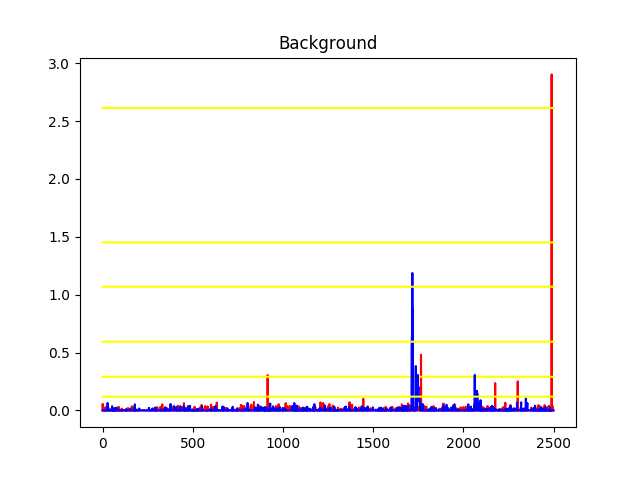

peak_count 329.0
min_len 1.0
max_len 59.0
avg_len 7.57750759878 

peak_count 3.0
min_len 724.0
max_len 915.0
avg_len 829.666666667 

peak_count 1.0
min_len 2489.0
max_len 2489.0
avg_len 2489.0 

peak_count 1.0
min_len 2489.0
max_len 2489.0
avg_len 2489.0 

peak_count 298.0
min_len 2.0
max_len 39.0
avg_len 8.36577181208 

peak_count 9.0
min_len 2.0
max_len 1715.0
avg_len 230.777777778 

peak_count 3.0
min_len 2.0
max_len 1715.0
avg_len 573.0 

peak_count 1.0
min_len 1717.0
max_len 1717.0
avg_len 1717.0 



In [59]:
if show_alpha:
    plt.plot(y_alpha, color='green')
    plt.plot(y_alpha_10p, color='yellow')
    plt.plot(y_alpha_50p, color='yellow')
    plt.plot(y_alpha_90p, color='yellow')
    plt.title('Alpha')
    y_alpha.print_features()
    
if show_beta:
    plt.plot(y_beta, color='red')
    plt.plot(y_beta_10p, color='yellow')
    plt.plot(y_beta_50p, color='yellow')
    plt.plot(y_beta_90p, color='yellow')
    plt.title('Beta')
    y_beta.print_features()
    
if show_back:
    plt.plot(y_back, color='blue')
    plt.plot(y_back_10p, color='yellow')
    plt.plot(y_back_50p, color='yellow')
    plt.plot(y_back_90p, color='yellow')
    plt.title('Background')
    y_back.print_features()

**Определим класс для каждого выборки**

----

In [65]:
t_size = my_dataset.shape[0]
t_size = t_size * 3 // 4
t_size

450

In [66]:
train_x = my_dataset.X[:t_size]
train_y = my_dataset.Y[:t_size]

test_x = my_dataset.X[t_size:]
test_y = my_dataset.Y[t_size:]

NameError: name 'back' is not defined

In [9]:
class RadiatonDataset(Dataset): 
    def __init__(self, x, y=None):
        self.data = x
        self.labels = y
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        if self.labels is not None:
            return data, label
        else:
            return data

In [10]:
train_dataset = RadiatonDataset(train_x, train_y)
test_dataset = RadiatonDataset(test_x, test_y)

trainloader = DataLoader(train_dataset, batch_size=t_size//4, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=t_size//4, shuffle=False)

In [11]:
t_size, testloader.batch_size

(12800, 3200)

**Построим примитивную модель**

----

**TODO** Add bias parametr for Linear function

In [116]:
class SigmoidBias(nn.Module):
    def __init__(self, bias=True):
        super(SigmoidBias, self).__init__()
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)
        if self.bias is not None:
            self.bias.data.uniform_(-0.1, 0.1)

    def forward(self, input):
        outut = torch.sigmoid(output)
        if self.bias is not None:
            output += self.bias.unsqueeze(0).expand_as(output)
        return output

In [15]:
class Net(nn.Module):  
    def __init__(self, input_features, output_features):
        super(Net, self).__init__()
        
        self.seq = nn.Sequential( \
                                    nn.Linear(input_features, 10),
                                    SigmoidBias(),
                                    nn.Linear(10, output_features)
                                )

    def forward(self, input): 
        x = self.seq(input)
        return x

**Обучим модель**


----

In [16]:
def run(s_epoch,n_epoch,lr):
    '''Only raw data'''
    net.train(True)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    for epoch in tqdm(range(s_epoch,n_epoch)):  
        running_corrects = 0
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs.float()).cuda(), Variable(labels).cuda()
            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.data[0]

            _, preds = torch.max(outputs.data, 1)
            running_corrects += torch.sum(preds == labels.data)
            
        loss_data.append(running_loss)
        corrects.append(running_corrects/len(trainloader.dataset))
    print ("Epoch %s, train accuracy %s and loss %s" %(epoch+1,running_corrects/len(trainloader.dataset),running_loss))
    print ('Finished Training')

In [ ]:
net = Net().cuda()
criterion = nn.CrossEntropyLoss()

loss_data = []
corrects = []

In [ ]:
run(0,5,0.01)

In [ ]:
run(5,30,0.01)

In [ ]:
net.train(False)

In [ ]:
classes = ('background', 'alpha', 'beta')
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

running_corrects=0
running_loss=0
y_hat = []
for data in testloader:
    inputs, labels = data
    outputs = net(Variable(inputs.float(), volatile=True).cuda())
    
    loss = criterion(outputs, Variable(labels, volatile=True).cuda())
    running_loss += loss.data[0]
    _, preds = torch.max(outputs.data, 1)
    running_corrects += torch.sum(preds.cpu() == labels)
    
    y_hat.append(outputs)
        
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted.cpu().numpy() == labels.numpy()).squeeze()
    for i in range(c.size):
        label = labels.numpy()[i]
        class_correct[label] += c[i]
        class_total[label] += 1 
print ("test accuracy %s and loss %s\n" %(running_corrects/len(testloader.dataset),running_loss))

for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
class_total[i]